In [3]:
import torch
import torch_geometric
from torch_geometric.data import Data
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import optuna
import training
import models
import metrics
from models import SpatioTemporalAutoencoder, TRACE_GCN
from parameters import STAEParameters, TrainingParameters
from datautils import get_morning_data, normalize_data, generate_edges, generate_relational_edges, load_best_parameters, get_full_data, label_anomalies
from training import save_model, load_model, train_TRACE_GCN, compute_anomaly_threshold_rstae, test_model, threshold_anomalies, fill_result_df, test_rstae
from metrics import calculate_accuracy, crash_detection_delay, calculate_tp_fp, find_thresholds, find_delays, find_percent, discrete_fp_delays, generate_anomaly_labels, calculate_auc
import torch.nn as nn
from tqdm import tqdm

import random
import os
seed=42
torch_geometric.seed_everything(seed)


def sequence_stae(data, timesteps, hide_anomalies=False):
    sequence = []
    relational_edges, relations = generate_relational_edges(milemarkers=list(range(49)), timesteps=timesteps)
    static_edges = generate_edges(milemarkers=list(range(49)))
    days = data['day']
    anomalies = data['anomaly']
    data_vals = data[['occ', 'speed', 'volume']]
    unix = data['unix_time']
    unique_times = np.unique(data['unix_time'])
    kept_indices = []

    for index, t in enumerate(tqdm(unique_times[timesteps:])): # skip first 'timesteps'
        data_t = []
        backward_index = range(index-1, index-timesteps-1, -1)
        backward_times = [unique_times[i] for i in backward_index]
        curr_day = np.unique(data[data['unix_time']==backward_times[-1]]['day'])[0]
        contains_anomaly = np.any([np.unique(data[data['unix_time']==i]['anomaly'])[0] for i in backward_times])
        is_curr_day = np.all([np.unique(data[data['unix_time']==i]['day'])[0]==curr_day for i in backward_times])

        if (hide_anomalies and contains_anomaly) or not is_curr_day:
            continue
        
        kept_indices.append(index+timesteps)

        for i in backward_times:
            data_t.append(Data(x=torch.tensor(data[data['unix_time']==i][['occ', 'speed', 'volume']].to_numpy(), dtype=torch.float32), edge_index=static_edges)) # assumes time indices come sequentially, with full data it may not

        curr_graph = data_t[0]
        sequence.append([data_t[::-1], curr_graph])

    return sequence, kept_indices

hide_anomalies = False
# optimal_params = load_best_parameters('TRACE_GCN',hide_anomalies=hide_anomalies)
study = optuna.study.load_study(
            study_name='TRACE_GCN',  # Replace with your study name
            storage=f"sqlite:///studies_non_hide/TRACE_GCN copy.db"  # Replace with the path to your SQLite database
        )
optimal_params = study.best_trial.params
print(optimal_params)
training_params = TrainingParameters(
    learning_rate=optimal_params['learning_rate'],
    batch_size=1,
    timesteps=optimal_params['timesteps'],
    n_epochs=optimal_params['epochs'],
)

{'dropout_rate': 0.3970633232826154, 'epochs': 4, 'flow_layers': 5, 'hidden_dim': 32, 'learning_rate': 1.062869085984312e-06, 'n_hidden_flow': 1, 'num_gcn_layers': 4, 'output_dim': 64, 'timesteps': 7}


In [4]:
data, test_data, _ = get_full_data()
data = normalize_data(data)
data = label_anomalies(data)
length = len(data.day.unique())
train_length = int(length * 0.8)
val_length = length - train_length
train_days = data.day.unique()[:train_length]
val_days = data.day.unique()[train_length:]

# Use .isin() to filter the DataFrame based on the days
train_data = data[data.day.isin(train_days)]
val_data = data[data.day.isin(val_days)]
train_sequence, kept_train_indices = sequence_stae(train_data, training_params.timesteps, hide_anomalies=hide_anomalies)
val_sequence, kept_val_indices = sequence_stae(val_data, training_params.timesteps, hide_anomalies=hide_anomalies)


100%|██████████| 2873/2873 [00:24<00:00, 117.23it/s]


In [5]:


num_features = 3
num_nodes = 196

model_params = {
    'input_features': num_features,
    # 'num_sensors': num_nodes,
    'hidden_dim': optimal_params['hidden_dim'],
    # 'num_transformer_layers': optimal_params['num_transformer_layers'],
    'output_dim': optimal_params['output_dim'],
    'num_gcn_layers': optimal_params['num_gcn_layers'],
    'flow_layers': optimal_params['flow_layers'],
    'n_hidden_flow':optimal_params['n_hidden_flow'],
    'dropout_rate':optimal_params['dropout_rate'],

    
}
using_pretrained = True

In [6]:
model = load_model(TRACE_GCN,model_params,f'TRACE_GCN_{hide_anomalies}_{seed}')

 25%|██▌       | 1/4 [03:15<09:46, 195.54s/it]

Epoch number 0 last 100 loss -348.2236318969727


 50%|█████     | 2/4 [06:09<06:06, 183.05s/it]

Epoch number 1 last 100 loss -637.1829986572266


 75%|███████▌  | 3/4 [09:04<02:59, 179.22s/it]

Epoch number 2 last 100 loss -1062.5498797607422


100%|██████████| 4/4 [11:59<00:00, 179.90s/it]

Epoch number 3 last 100 loss -1317.7041375732422


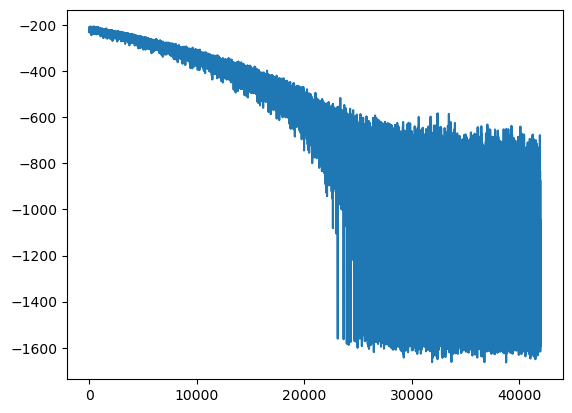

In [ ]:


if not using_pretrained:
    model, losses= train_TRACE_GCN(model_params, training_params, train_sequence,verbose=True)
    save_model(model, f'TRACE_GCN_{hide_anomalies}_{seed}' )
    plt.plot(losses)

else:
    # model=TRACE_GCN(**model_params)
    model = load_model(TRACE_GCN,model_params,f'TRACE_GCN_{hide_anomalies}_{seed}')
    

    

In [ ]:

thresh = training.compute_threshold_f_gtnf(val_sequence,model , 'max')

In [ ]:
_, df_test_data, _ = get_full_data()
test_data = normalize_data(df_test_data)
test_data = label_anomalies(test_data)
test_data, kept_test_indices = sequence_stae(test_data, training_params.timesteps, hide_anomalies=False)

100%|██████████| 4793/4793 [00:30<00:00, 157.82it/s]


In [ ]:
test_errors=training.test_f_gtnf(test_data, model, verbose=True)


100%|██████████| 4763/4763 [00:38<00:00, 124.17it/s]


In [ ]:
# Compute true anomaly labels
anomaly_labels = generate_anomaly_labels(df_test_data, kept_test_indices)

# Whether a crash was reported at each time
crash_reported = df_test_data['crash_record'].to_numpy()[0::196][kept_test_indices]

/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.loc[(test_data['unix_time'] - human_label_time <= 1800) & (test_data['unix_time'] - human_label_time >= 0), 'anomaly'] = 1
/media/vanderbilt/home/zulqarnain/freeway-anomaly-detection/code/metrics.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data.fillna(0, inplace=True)


In [ ]:
converted_dates_utc = pd.to_datetime(df_test_data.unix_time, unit='s', utc=True)

# Step 2: Convert to US/Central timezone
converted_dates_central = converted_dates_utc.dt.tz_convert('US/Central')
converted_dates_naive = converted_dates_central.dt.tz_localize(None)
df_test_data['Time']=converted_dates_naive

import glob
pattern=sorted(glob.glob('../data/event_data/2023-10-*.csv'))
events=pd.DataFrame()
for i in pattern:
    event=pd.read_csv(i,sep=';')
    events=pd.concat([events,event],axis=0)
events.reset_index(drop=True,inplace=True)
# events['timestamp']=pd.to_datetime(events['event_update_time'],utc=False)
events['Time'] = pd.to_datetime(events['event_update_time'], utc=False)

# To ensure the timestamps are naive (no timezone)
events['Time'] = events['Time'].dt.tz_localize(None).dt.floor('1s').dt.ceil('30s')
events=events[(events['event_update_type'] == 'new') & (events['classification']=='incident')]
events.drop_duplicates(subset=['event_id'],inplace=True)
events=events.sort_values(by='Time').reset_index(drop=True)


array1=np.array(events.milemarker.sort_values().unique())
array2=np.array(df_test_data.milemarker.unique())
def find_closest_or_exact(target, array):
    # Find the indices where the target would fit
    idx = np.searchsorted(array, target)
    
    # Check for exact match
    if idx < len(array) and array[idx] == target:
        return array[idx]  # Exact match
    
    # Find the closest lower value (if it exists)
    lower = array[idx - 1] if idx > 0 else None
    
    # Find the closest higher value (if it exists)
    higher = array[idx] if idx < len(array) else None
    
    return [lower, higher]

# Mapping from array2 to closest values in array1
events['mapped_milemarkers'] = events['milemarker'].apply(lambda x: find_closest_or_exact(x, array2))
events=events.explode('mapped_milemarkers')
# Filter events based on Time in df_test_data
test_events = events[events['Time'].isin(df_test_data['Time'])]

# Ensure 'Time' in test_events is properly converted to pandas.Timestamp
test_events['Time'] = pd.to_datetime(test_events['Time'])

df_test_data['combined'] = df_test_data['Time'].astype(str) + '_' + df_test_data['milemarker'].astype(str)
test_events['combined'] = test_events['Time'].astype(str) + '_' + test_events['mapped_milemarkers'].astype(str)

df_test_data['exists'] = df_test_data['combined'].isin(test_events['combined']).astype(int)
df_test_data['crash_record']=((df_test_data['exists'] == 1) & (df_test_data['crash_record'] == 1)
).astype(int)
crash_reported=df_test_data['crash_record'].to_numpy().reshape(-1,196)[kept_test_indices]
path_results = 'saved_results_loc/TRACE_GCN/'
results = metrics.discrete_fp_delays_loc_nll(thresh, test_errors, anomaly_labels, crash_reported)
if not os.path.exists(path_results):
    os.makedirs(path_results)
results.to_csv(f'{path_results}results_{hide_anomalies}_{seed}.csv', index=False)

/tmp/ipykernel_3508789/1502707724.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_data['Time']=converted_dates_naive
/tmp/ipykernel_3508789/1502707724.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_events['Time'] = pd.to_datetime(test_events['Time'])
/tmp/ipykernel_3508789/1502707724.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

[[1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.913330078125], [1.0, 2564.

In [ ]:
calculate_auc(test_errors,anomaly_labels)

0.5